In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage
import skimage.io as io
import matplotlib.pyplot as plt
import time
import pandas as pd
import math
from tqdm import tqdm

In [2]:
dataType = 'val2017'
annFile = f'coco/annotations/instances_{dataType}.json'
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!


## Loading Categories
We can use the commands below to load object categories as well as the "supercategories" that they belong to

In [3]:
items = coco.loadCats(coco.getCatIds())
categories = [item['name'] for item in items]
supercategories = set([item['supercategory'] for item in items])
print(f'{len(categories)} Total Categories:')
print(categories)
print(f'{len(supercategories)} Total SuperCategories:')
print(supercategories)

80 Total Categories:
['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
12 Total SuperCategories:
{'furniture', 'appliance', 'sports', 'electronic', 'indoor', 'food', 'vehicle', 'outdoor', 

Using supercategories is helpful to filter to a subset of categories that will be more pertinent to the task we want to transfer to. This might not be necessary, but something worth being aware of.

In [4]:
filtered_items = coco.loadCats(coco.getCatIds(supNms=['kitchen', 'furniture', 'indoor', 'appliance', 'outdoor']))
categories = [item['name'] for item in filtered_items]
supercategories = set([item['supercategory'] for item in filtered_items])
print(f'{len(categories)} Total Categories:')
print(categories)
print(f'{len(supercategories)} Total SuperCategories:')
print(supercategories)

30 Total Categories:
['traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
5 Total SuperCategories:
{'furniture', 'appliance', 'indoor', 'outdoor', 'kitchen'}


## Loading Image IDs

The COCO object stores image IDs as a nested dictionary where each ID is the key and the value is a dictionary with image metadata (url, height, width, date captured, etc.). We can access image IDs by just calling list(coco.imgs.keys()). Note that there are only 5000 total images in this dataset to keep things manageable for local exploration.

In [5]:
imgs = coco.imgs
img_ids = list(imgs.keys())
print(img_ids[:10])
print(f'Total Number of Images in {dataType} split:', len(img_ids))

[397133, 37777, 252219, 87038, 174482, 403385, 6818, 480985, 458054, 331352]
Total Number of Images in val2017 split: 5000


In [6]:
img_id = 397133
coco.imgToAnns[img_id][0].keys()


dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])

## Getting Object Labels for Images

The goal is to get our data initially in tabular format where a given image (represented by an img_id and a link to the image) corresponds to its object labels ("categories" in MS COCO speak)

The first step to doing this is figuring out how to extract all "category" labels / tags for a given img_id, so that we can apply this to all img_ids.

Next, we can load all images with their corresponding tags into a dataframe.

In [7]:
# Get all the category names for a given image
img_id = 397133

def getImgLabels(img_id: int) -> list:
    '''
    Takes in an image ID from the COCO dataset and returns all associated objects identified in the corresponding image.

    '''
    annotations = coco.imgToAnns[img_id]
    category_ids = [coco.imgToAnns[img_id][i]['category_id'] for i in range(len(coco.imgToAnns[img_id]))]
    category_names = [item['name'] for item in coco.loadCats(category_ids)]
    return list(set(category_names))

category_names = getImgLabels(img_id)
print(f'Category Names for img_id {img_id}:')
print(category_names)



Category Names for img_id 397133:
['broccoli', 'dining table', 'sink', 'bottle', 'cup', 'bowl', 'knife', 'spoon', 'carrot', 'oven', 'person']


In [8]:
# Get all category names for all images and organize into a dataframe
img_tags_data = pd.DataFrame({'img_id': img_ids})
img_tags_data['img_local_url'] = img_tags_data['img_id'].apply(lambda x: f"coco/images/{'0'*(12-len(str(x))) + str(x)}.jpg")
img_tags_data['tags'] = img_tags_data['img_id'].apply(lambda x: getImgLabels(x))
img_tags_data.head()

,img_id,img_local_url,tags
0,397133,coco/images/000000397133.jpg,"[broccoli, dining table, sink, bottle, cup, bo..."
1,37777,coco/images/000000037777.jpg,"[orange, banana, dining table, sink, potted pl..."
2,252219,coco/images/000000252219.jpg,"[umbrella, traffic light, cup, handbag, person]"
3,87038,coco/images/000000087038.jpg,"[skateboard, bicycle, person]"
4,174482,coco/images/000000174482.jpg,"[car, truck, bicycle, traffic light]"


In [9]:
# Check that datatypes look right
img_tags_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   img_id         5000 non-null   int64 
 1   img_local_url  5000 non-null   object
 2   tags           5000 non-null   object
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


We can print the image for 397133 to visually verify that the tags look right after applying our method:

Local URL: coco/images/000000397133.jpg
Online lmage URL: http://images.cocodataset.org/val2017/000000397133.jpg
Local image load time: 0.010968923568725586
Online image load time: 0.1879122257232666


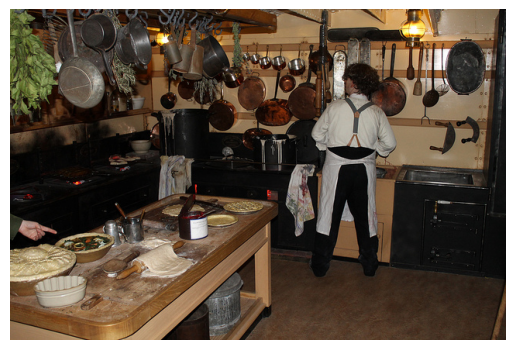

In [10]:
img_row = img_tags_data.iloc[0,:]
img = coco.loadImgs(int(img_row['img_id']))[0]
print('Local URL:', img_row['img_local_url'])
print('Online lmage URL:', img['coco_url'])

t0 = time.time()
I = io.imread(img_row['img_local_url'])
t1 = time.time()
I = io.imread(img['coco_url'])
t2 = time.time()

print('Local image load time:', t1-t0)
print('Online image load time:', t2-t1)

plt.axis('off')
plt.imshow(I)
plt.show()

## Image Preprocessing

To prepare images for CLIP encoding, we apply some standardizing transformations:
1. Pad all images to the same square dimensions (determined by the biggest dimension from all images)
2. Convert to RGB (if images are in grayscale, i.e. (HxWx1)-dimensional instead of (HxWx3)-dimensional)
3. Normalize with mean (0.48, 0.46, 0.41) and std deviation (0.27, 0.26, 0.28)

In [11]:
def to_rgb(img):
    return skimage.color.gray2rgb(img) if len(img.shape) < 3 or img.shape[2] < 3 else img


def pad_to_square(img, target_dim):
    '''
    Takes in 3D image representation from io.imread(), crops image into square shape 
    min(width, height) x min(width, height) (assuming all images are the same size)
    '''
    v_padding = (target_dim - img.shape[0]) / 2 if img.shape[0] < target_dim else 0
    h_padding = (target_dim - img.shape[1]) / 2 if img.shape[1] < target_dim else 0

    img_padded = np.pad(img, ((int(math.floor(v_padding)), int(math.ceil(v_padding))), 
                              (int(math.floor(h_padding)), int(math.ceil(h_padding))),
                              (0, 0)),
                              'constant', constant_values=((0,0), (0,0), (0,0)))
    return img_padded


def norm_image(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))


In [12]:
# Get maximum dimension for padding
heights = []
widths = []
for i in tqdm(range(len(img_tags_data)), desc='computing target dimension'):
    row = img_tags_data.iloc[i,:]
    image = io.imread(row['img_local_url'])
    heights.append(image.shape[0])
    widths.append(image.shape[1])

target_dim = max(max(heights), max(widths))

# Pre-process all images using the steps outlined above
img_matrices = {}
#labels_matrix = np.empty()
for i in tqdm(range(len(img_tags_data)), desc='pre-processing images'):
    row = img_tags_data.iloc[i,:]
    image = io.imread(row['img_local_url'])

    image_rgb = to_rgb(image)
    image_rgb_pad = pad_to_square(image_rgb, target_dim)
    image_rgb_pad_norm = norm_image(image_rgb_pad)

    img_matrices[row['img_id']] = image_rgb_pad_norm
    

pre-processing images: 100%|██████████| 5000/5000 [00:49<00:00, 101.56it/s]


Test Image shape: (640, 640, 3)
Test Image Pixel Color Means: ([0.21072381 0.1710833  0.13089082])
Test Image Pixel Values Min / Max: (0.0, 1.0)


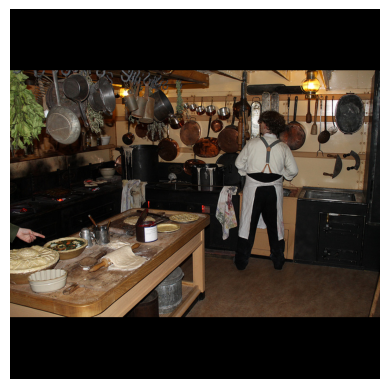

In [13]:
test_img = img_matrices[397133]
print('Test Image shape:', test_img.shape)
print(f'Test Image Pixel Color Means: ({np.mean(test_img, axis=(0,1))})')
print(f'Test Image Pixel Values Min / Max: {np.min(test_img), np.max(test_img)}')
plt.axis('off')
plt.imshow(test_img)
plt.show()

## Load Captions Data

In [14]:
annFileCaptions = f'coco/annotations/captions_{dataType}.json'
coco_caps=COCO(annFileCaptions)

loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


In [15]:
def get_captions(img_id):
    annIds = coco_caps.getAnnIds(imgIds=img_id)
    anns = coco_caps.loadAnns(annIds)
    captions = [ann['caption'] for ann in anns]
    return captions
img_tags_data['captions'] = img_tags_data['img_id'].apply(lambda x: get_captions(x))
img_tags_data.head()

,img_id,img_local_url,tags,captions
0,397133,coco/images/000000397133.jpg,"[broccoli, dining table, sink, bottle, cup, bo...","[A man is in a kitchen making pizzas., Man in ..."
1,37777,coco/images/000000037777.jpg,"[orange, banana, dining table, sink, potted pl...",[The dining table near the kitchen has a bowl ...
2,252219,coco/images/000000252219.jpg,"[umbrella, traffic light, cup, handbag, person]",[a person with a shopping cart on a city stree...
3,87038,coco/images/000000087038.jpg,"[skateboard, bicycle, person]",[A person on a skateboard and bike at a skate ...
4,174482,coco/images/000000174482.jpg,"[car, truck, bicycle, traffic light]","[a blue bike parked on a side walk , A bicycle..."
